Izgradnja mreže za prepoznavanje govora koja prepoznaje 10 različitih riječi.
--> Model koji klasificira jednosekundni audio-zapis riječi : "dolje", "idi", "lijevo", "ne", "desno", "stani", "gore" "i" da ".

OS modul u pythonu pruža funkcije za interakciju s operativnim sustavom. Ovaj modul pruža prijenosni način korištenja funkcionalnosti ovisne o operativnom sustavu. Moduli * os * i * os.path * uključuju brojne funkcije za interakciju s datotečnim sustavom.

Pathlib modul u Pythonu pruža različite klase koje predstavljaju staze datotečnog sustava sa semantikom prikladnom za različite operativne sustave. Ovaj modul potpada pod Pythonove standardne uslužne module.



In [ ]:
import os
import pathlib

import matplotlib.pyplot as plt # za grafove
import numpy as np # za matematicke operacije nad nizovima
import seaborn as sns #biblioteka za vizualizaciju podataka, pruža sučelje za crtanje statističkih grafova
import tensorflow as tf # ovako uvozimo sva sučelja TensorFlowa koja je nalaze na jednom mjesto kao podmoduli

from tensorflow.keras.layers.experimental import preprocessing  ## predprocesiranje
from tensorflow.keras import layers ## slojevi  (neuronske mreze)
from tensorflow.keras import models ## model
from IPython import display # Pythonovi alati za display 


# Postavljamo vrijednosti seed-a (sjeme) za reprodukcijabilnost eksperimenta (zbog ponavljanja eksperimenta)
seed = 42
tf.random.set_seed(seed) 
np.random.seed(seed)

# Uvoz skupa podataka Govorne naredbe 

Ovdje će biti napisana skripta za preuzimanje dijela skupa podataka Govorne naredbe. Izvorni skup podataka sastoji se od preko 105 000 WAV audio datoteka ljudi koji izgovaraju trideset različitih riječi. Te je podatke prikupio Google i objavio ih pod licencom CC BY.

Bit će upotrebljen dio skupa podataka kako bi se uštedjelo vrijeme prilikom učitavanja podataka. Izdvojen je mini_speech_commands.zip i učitan pomoću tf.data API-ja.

In [ ]:
data_dir = pathlib.Path('data/mini_speech_commands')
if not data_dir.exists():
  tf.keras.utils.get_file(
      'mini_speech_commands.zip',
      origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
      extract=True,
      cache_dir='.', cache_subdir='data')

182083584/182082353 [==============================] - 1s 0us/step


Provjera osnovnih statistika skupa podataka

In [ ]:
commands = np.array(tf.io.gfile.listdir(str(data_dir)))
commands = commands[commands != 'README.md']
print('Commands:', commands)

Commands: ['no' 'up' 'yes' 'down' 'left' 'right' 'go' 'stop']


Izdvojanje audio datoteka na popis. Treba ih i pomiješati pa je i to urađeno.

In [ ]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
print('Number of total examples:', num_samples)
print('Number of examples per label:',
      len(tf.io.gfile.listdir(str(data_dir/commands[0]))))
print('Example file tensor:', filenames[0])

Number of total examples: 8000
Number of examples per label: 1000
Example file tensor: tf.Tensor(b'data/mini_speech_commands/go/26b28ea7_nohash_2.wav', shape=(), dtype=string)


Datoteke se dijele u skupove za trening, validaciju i test, koristeći omjer 80:10:10.

In [ ]:
train_files = filenames[:6400]
val_files = filenames[6400: 6400 + 800]
test_files = filenames[-800:]

print('Training set size', len(train_files))
print('Validation set size', len(val_files))
print('Test set size', len(test_files))

Training set size 6400
Validation set size 800
Test set size 800


## Čitanje audio datoteka i njihovih labela

Zvučna datoteka u početku će se čitati kao binarna datoteka koja će biti pretvorena u numerički tenzor.

Za učitavanje audio datoteke, upotrijebljen je [`tf.audio.decode_wav`] (https://www.tensorflow.org/api_docs/python/tf/audio/decode_wav), koji vraća kodiran WAV zvuk kao tenzor i stopu uzorkovanja.

WAV datoteka sadrži podatke o vremenskim serijama sa zadanim brojem uzoraka u sekundi.
Svaki uzorak predstavlja amplitudu audio signala u to određeno vrijeme. U 16-bitnom sustavu, poput datoteka u `mini_speech_commands`, vrijednosti se kreću od -32768 do 32767.
Brzina uzorkovanja za ovaj skup podataka je 16kHz.
`tf.audio.decode_wav` će normalizirati vrijednosti na raspon [-1,0, 1,0].

In [ ]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(audio_binary)
  return tf.squeeze(audio, axis=-1)

Oznaka za svaku WAV datoteku je njezin nadređeni direktorij.

In [ ]:
def get_label(file_path):
  parts = tf.strings.split(file_path, os.path.sep)

  # Note: You'll use indexing here instead of tuple unpacking to enable this 
  # to work in a TensorFlow graph.
  return parts[-2] 

Definiranje metode koja će uzeti naziv datoteke WAV datoteke i izbaciti tupu koja sadrži zvuk i oznake za nadgledani trening.

In [ ]:
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label

Primjena process_path za izradu skupa za trening i za izdvajanje parova audio-naljepnica te provjeru rezultata. Kasnije se pomoću sličnog postupka izrađuju skupovi za validaciju i test.

In [ ]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
files_ds = tf.data.Dataset.from_tensor_slices(train_files)
waveform_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)

+ Ispitivanje nekoliko zvučnih oblika s pripadajućim oznakama.

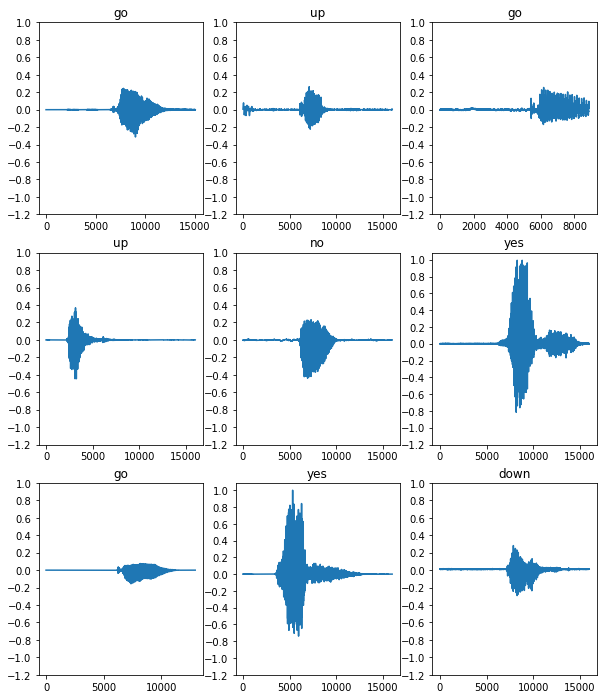

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 12))
for i, (audio, label) in enumerate(waveform_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  ax.plot(audio.numpy())
  ax.set_yticks(np.arange(-1.2, 1.2, 0.2))
  label = label.numpy().decode('utf-8')
  ax.set_title(label)

plt.show()

## Spektrogram

Valni oblik treba pretvoriti  u spektrogram, koji prikazuje promjene frekvencije tijekom vremena i može se predstaviti kao 2D slika. To se može učiniti primjenom kratkotrajne Fourierove transformacije (STFT) za pretvorbu zvuka u vremensko-frekvencijsku domenu.

Fourierova transformacija ([`tf.signal.fft`] (https://www.tensorflow.org/api_docs/python/tf/signal/fft)) pretvara signal u njegove frekvencijske komponente, ali gubi sve vremenske informacije. STFT ([`tf.signal.stft`] (https://www.tensorflow.org/api_docs/python/tf/signal/stft)) razdvaja signal na prozore vremena i pokreće Fourierovu transformaciju na svakom prozoru, čuvanje nekih podataka o vremenu i vraćanje 2D tenzora na kojem možete pokretati standardne konvolucije.

STFT proizvodi niz složenih brojeva koji predstavljaju veličinu i fazu. Međutim, trebat će vam samo veličina za ovaj vodič, koja se može izvesti primjenom `tf.abs` na izlazu` tf.signal.stft`.

Odabiru se parametri `frame_length` i` frame_step` tako da generirana "slika" spektrograma bude gotovo četvrtasta. Za više informacija o odabiru STFT parametara, možemo pogledati [ovaj video] (https://www.coursera.org/lecture/audio-signal-processing/stft-2-tjEQe) o obradi audio signala.

Također valni oblici bi trebali imati istu duljinu, tako da će, kada ih pretvorimo u sliku spektrograma, rezultati imati slične dimenzije. To se može postići jednostavnim dodavanjem nule na podpunu audio zapisa koji su kraći od jedne sekunde.

In [ ]:
def get_spectrogram(waveform):
  # Padding for files with less than 16000 samples
  zero_padding = tf.zeros([16000] - tf.shape(waveform), dtype=tf.float32)

  # Concatenate audio with padding so that all audio clips will be of the 
  # same length
  waveform = tf.cast(waveform, tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
      
  spectrogram = tf.abs(spectrogram)

  return spectrogram

Zatim se istražuju podaci. Uspoređuje se valni oblik, spektrogram i stvarni zvuk jednog primjera iz skupa podataka.

In [ ]:
for waveform, label in waveform_ds.take(1):
  label = label.numpy().decode('utf-8')
  spectrogram = get_spectrogram(waveform)

print('Label:', label)
print('Waveform shape:', waveform.shape)
print('Spectrogram shape:', spectrogram.shape)
print('Audio playback')
display.display(display.Audio(waveform, rate=16000))

Label: go
Waveform shape: (15019,)
Spectrogram shape: (124, 129)
Audio playback


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


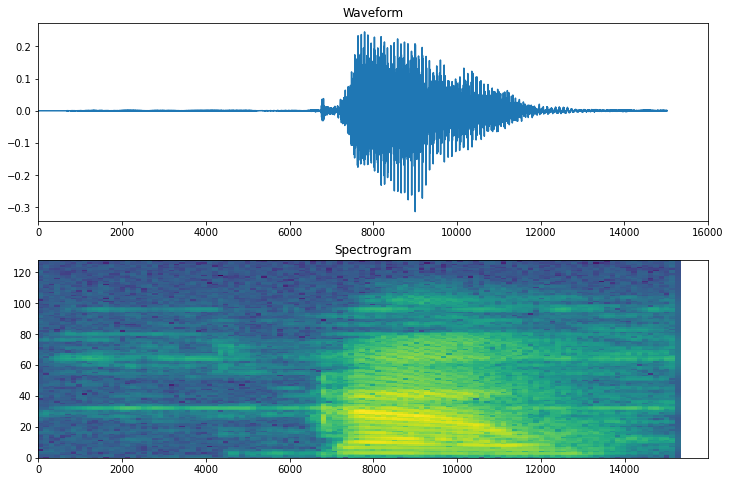

In [ ]:
def plot_spectrogram(spectrogram, ax):
  # Convert to frequencies to log scale and transpose so that the time is
  # represented in the x-axis (columns).
  log_spec = np.log(spectrogram.T)
  height = log_spec.shape[0]
  X = np.arange(16000, step=height + 1)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)


fig, axes = plt.subplots(2, figsize=(12, 8))
timescale = np.arange(waveform.shape[0])
axes[0].plot(timescale, waveform.numpy())
axes[0].set_title('Waveform')
axes[0].set_xlim([0, 16000])
plot_spectrogram(spectrogram.numpy(), axes[1])
axes[1].set_title('Spectrogram')
plt.show()

Sada se transformira skup podataka valnih oblika kako bi se dobile slike spektrograma i njihove odgovarajuće oznake kao cjelobrojni ID-ovi.

In [ ]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  spectrogram = tf.expand_dims(spectrogram, -1)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [ ]:
spectrogram_ds = waveform_ds.map(
    get_spectrogram_and_label_id, num_parallel_calls=AUTOTUNE)

Ispituju se "slike" spektrograma za različite uzorke skupa podataka.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:4: RuntimeWarning: divide by zero encountered in log
  after removing the cwd from sys.path.


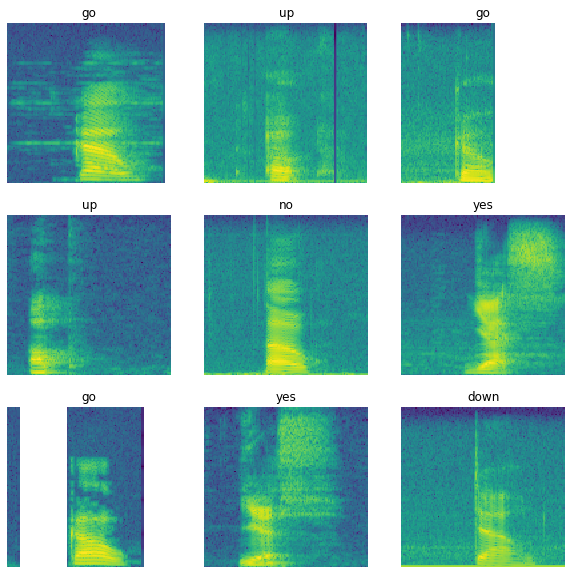

In [ ]:
rows = 3
cols = 3
n = rows*cols
fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
for i, (spectrogram, label_id) in enumerate(spectrogram_ds.take(n)):
  r = i // cols
  c = i % cols
  ax = axes[r][c]
  plot_spectrogram(np.squeeze(spectrogram.numpy()), ax)
  ax.set_title(commands[label_id.numpy()])
  ax.axis('off')
  
plt.show()

## Izrada i obučavanje modela

Sada se može graditi i trenirati model. Ali prije toga, mora se ponoviti predobrada skupa treninga na validacijskim i testnim setovima.

In [ ]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(get_waveform_and_label, num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      get_spectrogram_and_label_id,  num_parallel_calls=AUTOTUNE)
  return output_ds

In [ ]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)

Skupljaju se setovi za obuku i provjeru valjanosti za obuku modela.

In [ ]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)

Dodaju se operacije predmemorije skupa podataka () i prefetch () kako bi se smanjilo kašnjenje čitanja tijekom obuke modela.

In [ ]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)

Za model se upotrebljava jednostavna konvolucijsku neuronsku mrežu (CNN), budući da su audio datoteke transformirane u spektrogramske slike.
Model također ima sljedeće dodatne slojeve predobrade:
- Sloj [`Resizing '] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Resizing) za smanjenje uzorka ulaznih podataka kako bi se model mogao brže trenirati.
- Sloj [`Normalizacija`] (https://www.tensorflow.org/api_docs/python/tf/keras/layers/experimental/preprocessing/Normalization) sloj za normalizaciju svakog piksela na slici na temelju njegove srednje vrijednosti i standardne devijacije.

Za sloj `Normalizacija`, njegova metoda` prilagodbe` prvo bi trebala biti pozvana na podacima o obuci kako bi se izračunala zbirna statistika (tj. Srednja i standardna devijacija).

In [ ]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
print('Input shape:', input_shape)
num_labels = len(commands)

norm_layer = preprocessing.Normalization()
norm_layer.adapt(spectrogram_ds.map(lambda x, _: x))

model = models.Sequential([
    layers.Input(shape=input_shape),
    preprocessing.Resizing(32, 32), 
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])

model.summary()

Input shape: (124, 129, 1)
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
resizing_1 (Resizing)        (None, 32, 32, 1)         0         
_________________________________________________________________
normalization_1 (Normalizati (None, 32, 32, 1)         3         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        320       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 64)        0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 14, 14, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)        

In [ ]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [ ]:
EPOCHS = 10
history = model.fit(
    train_ds, 
    validation_data=val_ds,  
    epochs=EPOCHS,
    callbacks=tf.keras.callbacks.EarlyStopping(verbose=1, patience=2),
)

Epoch 1/10
100/100 [==============================] - 36s 361ms/step - loss: 1.7612 - accuracy: 0.3695 - val_loss: 1.3492 - val_accuracy: 0.5975
Epoch 2/10
100/100 [==============================] - 20s 197ms/step - loss: 1.2139 - accuracy: 0.5786 - val_loss: 0.9358 - val_accuracy: 0.7250
Epoch 3/10
100/100 [==============================] - 20s 196ms/step - loss: 0.9087 - accuracy: 0.6812 - val_loss: 0.7465 - val_accuracy: 0.7550
Epoch 4/10
100/100 [==============================] - 19s 193ms/step - loss: 0.7242 - accuracy: 0.7395 - val_loss: 0.6632 - val_accuracy: 0.7775
Epoch 5/10
100/100 [==============================] - 20s 196ms/step - loss: 0.6180 - accuracy: 0.7803 - val_loss: 0.5827 - val_accuracy: 0.8025
Epoch 6/10
100/100 [==============================] - 19s 195ms/step - loss: 0.5501 - accuracy: 0.8095 - val_loss: 0.5581 - val_accuracy: 0.7987
Epoch 7/10
100/100 [==============================] - 19s 194ms/step - loss: 0.4832 - accuracy: 0.8273 - val_loss: 0.5613 - val_ac

Provjera krivulje gubitka treninga i validacije kako bi se vidjelo kako se model poboljšao tijekom treninga

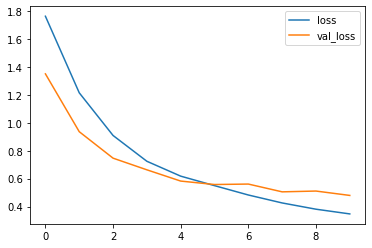

In [ ]:
metrics = history.history
plt.plot(history.epoch, metrics['loss'], metrics['val_loss'])
plt.legend(['loss', 'val_loss'])
plt.show()

## Procijena izvedbe testnog skupa

Pokretanje modela na testnom skupu i provjera izvedbe.

In [ ]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [ ]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 84%


### Prikaz matrice konfuzije

Matrica konfuzije je korisna da se vidi koliko je model dobro prošao u svakoj od naredbi u testnom skupu.

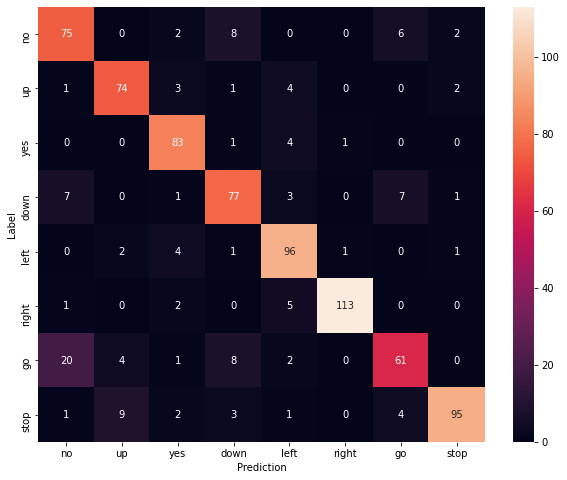

In [ ]:
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=commands, yticklabels=commands, 
            annot=True, fmt='g')
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Pokretanje zaključaka na audio datoteci

Na kraju, provjera se, npr. izlaz predviđanja modela pomoću ulazne audio datoteke nekoga tko je rekao "ne". Evo koliko je model dobro to odredio... 

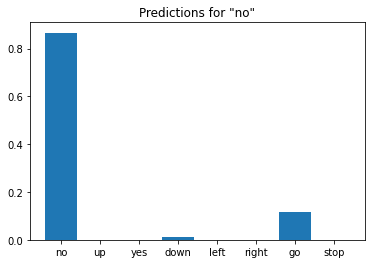

In [ ]:
sample_file = data_dir/'no/01bb6a2a_nohash_0.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()

Može se vidjeti da je model vrlo jasno prepoznao zvučnu naredbu kao "ne".